## Task

In this task, we will try to do sentiment analysis using both images and text. Sounds fun, right!

We have the dataset [MVSA: Sentiment Analysis on Multi-view Social Data](https://mcrlab.net/research/mvsa-sentiment-analysis-on-multi-view-social-data/) which is a collection of tweets which include both text and images.

Your job is the following:
1. Read and process the dataset (images, text, and their labels) and divide into train and test dataset (80:20 split).
2. Build, train and evaluate a CNN which only uses images for sentiment analysis
3. Build, train and evaluate a Text model which only uses the text data for sentiment analalysis (You can use any of RNN/LSTM/GRU)
4. Build, train and evaluate a combined model which uses both visual aand text data.
5. Do a performance comparsion of these three different kinds of models. Also plot confusion matrices for all of them.

Here's how the combined model would look like.

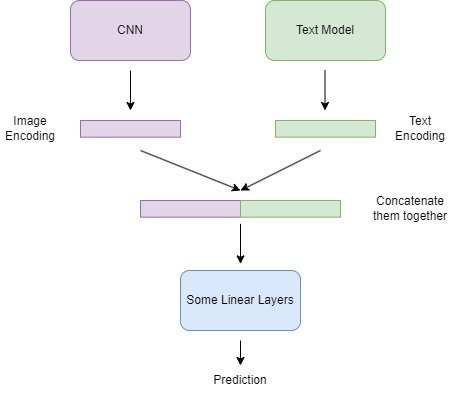

In [1]:
# Alternative loading of data from drive folder
#from google.colab import drive
#drive.mount("content/drive")

In [2]:
from IPython.display import clear_output
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch

In [3]:
# Check and set which device type is available

device = "cpu"

if torch.cuda.is_available():
  device = "cuda"

print(f"Using device: {device}")

Using device: cuda


In [4]:
!gdown "1w2zPSfyAoSopS-BhFurKayYa_OhjI9YH"

Downloading...
From (original): https://drive.google.com/uc?id=1w2zPSfyAoSopS-BhFurKayYa_OhjI9YH
From (redirected): https://drive.google.com/uc?id=1w2zPSfyAoSopS-BhFurKayYa_OhjI9YH&confirm=t&uuid=f2d5a91e-b677-45d1-9844-ca0e97300708
To: /content/MVSA-Single.zip
100% 211M/211M [00:01<00:00, 184MB/s]


In [5]:
!unzip MVSA-Single.zip
clear_output()

In [6]:
df = pd.read_csv("MVSA_Single/labelResultAll.csv")

# Initialize and fit the label encoder
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Data Inspection

In [7]:
df.head()

,ID,label,label_encoded
0,1,positive,2
1,2,positive,2
2,3,positive,2
3,4,positive,2
4,5,positive,2


In [8]:
# Get the count of NaN values for each column

nan_counts = df.isna().sum()
print(nan_counts)

ID               0
label            0
label_encoded    0
dtype: int64


In [9]:
# Print unique labels

unique_labels = set(df["label"])
print(unique_labels)

{'neutral', 'positive', 'negative'}


In [10]:
# Print an example of each class

# Positive
print(df.iloc[0])

# Negative
print(df.iloc[18])

# Neutral
print(df.iloc[26])

ID                      1
label            positive
label_encoded           2
Name: 0, dtype: object
ID                     19
label            negative
label_encoded           0
Name: 18, dtype: object
ID                    27
label            neutral
label_encoded          1
Name: 26, dtype: object


In [11]:
# Count and print the occurrences of each label

label_counts = df['label'].value_counts()
print(label_counts)

label
positive    2708
negative    1223
neutral      938
Name: count, dtype: int64


# Main Imports

In [12]:
import os
from collections import Counter

from torch.nn.functional import max_pool2d, cross_entropy
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam, SGD

from PIL import Image

from torchvision import transforms
from torchvision.transforms.functional import to_tensor
from torchvision.models import resnet18, resnet34, resnet50


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

# Creating a DataSet

In [13]:
# Image custom transforms

resitze_transform = transforms.Resize((224,224), antialias=False)

# Resize and pad
class Translate:
    def __init__(self, target_size=(224, 224), padding_color=(0, 0, 0)):
        """
        Initialize the Translate class with target size and padding color.

        :param target_size: Tuple (width, height) - the target size to resize and pad the images to.
        :param padding_color: Tuple (R, G, B) - the color of the padding. Default is black.
        """
        self.target_size = target_size
        self.padding_color = padding_color

    def __call__(self, image):
        """
        Resize and pad the image while maintaining its aspect ratio.

        :param image: PIL.Image object, the image to be resized and padded.
        :return: PIL.Image object - the resized and padded image.
        """
        original_size = image.size
        ratio = min(self.target_size[0] / original_size[0], self.target_size[1] / original_size[1])
        new_size = (int(original_size[0] * ratio), int(original_size[1] * ratio))
        resized_image = image.resize(new_size, Image.LANCZOS)

        new_image = Image.new("RGB", self.target_size, self.padding_color)
        top_left = ((self.target_size[0] - new_size[0]) // 2, (self.target_size[1] - new_size[1]) // 2)
        new_image.paste(resized_image, top_left)

        return new_image

In [14]:
# Text Preprocessing functions

def preprocess_text(text):
    text = text.lower()
    # text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

def read_txt_files(directory_path):
    # List to store contents of all txt files
    all_contents = []

    # List all files in the directory
    for file in os.listdir(directory_path):
        if file.endswith(".txt"):
            # Get the full path of the file
            file_path = os.path.join(directory_path, file)

            # Open the file and read its content
            with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
                content = f.read()

                # Append the content to the list
                all_contents.append(content)

    return all_contents

In [15]:
# Define my own Dataset class

class CombinedDataset(Dataset):
  def __init__(self, labels: pd.DataFrame, path_data: str, vocab, max_len=50, img_trans=None):
    self.path_data = path_data
    self.df = labels
    self.img_trans = img_trans
    self.vocab = vocab
    self.max_len = max_len

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    df_row = self.df.iloc[idx]
    df_row_id = df_row["ID"]

    # Image
    img = Image.open(f"{self.path_data}/{str(df_row_id)}.jpg")
    if self.img_trans is not None:
      img = self.img_trans(img)

    # Text
    text = open(f"{self.path_data}/{str(df_row_id)}.txt", encoding='utf-8', errors='replace').read()
    text = preprocess_text(text)
    tokens = text.split()
    # Convert tokens to indices
    indices = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
    # Pad or truncate to max_len
    indices = indices[:self.max_len] + [self.vocab['<PAD>']] * (self.max_len - len(indices))
    text_tensor_indicies = torch.tensor(indices)

    # Label
    label = df_row["label_encoded"]

    return img, text, text_tensor_indicies, label

In [16]:
# Build the vocabulary

text_ls = read_txt_files("MVSA_Single/data/")

all_tokens = [token for text in text_ls for token in preprocess_text(text).split()]
vocab = {token: idx + 2 for idx, token in enumerate(Counter(all_tokens))} # give all tokens a unique number. 0 and 1 are reserved for padding and unknown
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

In [17]:
# Instanciate my dataset class and transforms

resize_pad = Translate(target_size=(224, 224), padding_color=(0, 0, 0))

trans = transforms.Compose([resize_pad, transforms.ToTensor()])
dataset = CombinedDataset(df, "MVSA_Single/data/", vocab, img_trans=trans)

In [18]:
# Define the size of the train and test data splits (80/20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [19]:
# Create DataLoader

batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [20]:
# Test if everything worked
image, text, text_tensor, label = next(iter(train_loader))

print(image[0].shape)
print(text[0])
print(text_tensor[0].shape)
print(label[0])

torch.Size([3, 224, 224])
lmfao! 10 hot girl selfies ruined 

torch.Size([50])
tensor(2)


# Image Model

In [21]:
%%time

# Define ResNet model
model = resnet34(pretrained=True)  # Load pretrained weights

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(unique_labels))

# Only the parameters of the final fully connected layer will be updated during training
model.fc.requires_grad = True

# Move model to the specified device
model = model.to(device)

# Training and Evaluation
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)  # Only optimize the final fully connected layer

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 119MB/s]


CPU times: user 835 ms, sys: 373 ms, total: 1.21 s
Wall time: 1.49 s


In [22]:
%%time
# Train and evaluate
num_epochs = 9
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    for images, _, _, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, _, _, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = running_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%")

Epoch 1/9 - Train Loss: 1.0366, Validation Loss: 0.9442, Accuracy: 56.78%
Epoch 2/9 - Train Loss: 0.9370, Validation Loss: 0.8931, Accuracy: 58.62%
Epoch 3/9 - Train Loss: 0.8960, Validation Loss: 0.8793, Accuracy: 60.37%
Epoch 4/9 - Train Loss: 0.8706, Validation Loss: 0.8677, Accuracy: 60.68%
Epoch 5/9 - Train Loss: 0.8517, Validation Loss: 0.8601, Accuracy: 60.99%
Epoch 6/9 - Train Loss: 0.8375, Validation Loss: 0.8558, Accuracy: 60.27%
Epoch 7/9 - Train Loss: 0.8261, Validation Loss: 0.8528, Accuracy: 61.09%
Epoch 8/9 - Train Loss: 0.8164, Validation Loss: 0.8507, Accuracy: 61.09%
Epoch 9/9 - Train Loss: 0.8081, Validation Loss: 0.8495, Accuracy: 61.29%
CPU times: user 6min 40s, sys: 18.7 s, total: 6min 59s
Wall time: 7min 3s


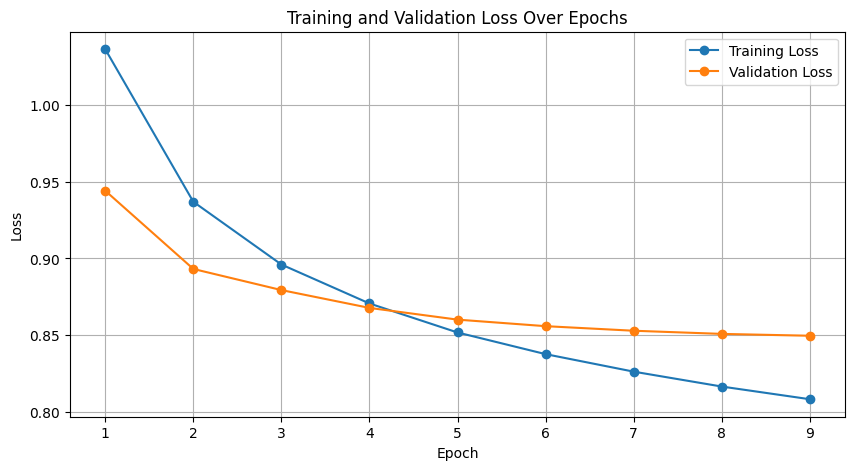

In [23]:
# Plotting the loss curves

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Evaluation and Classification Report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for image, _, _, label in test_loader:
        image, label = image.to(device), label.to(device)

        # Forward pass
        output = model(image)

        # Convert output to predicted class labels
        preds = torch.argmax(output, dim=1)

        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy()) # better compatibility from pytorch tensor
        all_labels.extend(label.cpu().numpy())

# Generate the classification report
report = classification_report(all_labels, all_preds, target_names=unique_labels)
print(report)

              precision    recall  f1-score   support

     neutral       0.50      0.31      0.38       241
    positive       0.51      0.46      0.48       191
    negative       0.67      0.80      0.73       542

    accuracy                           0.61       974
   macro avg       0.56      0.52      0.53       974
weighted avg       0.59      0.61      0.59       974



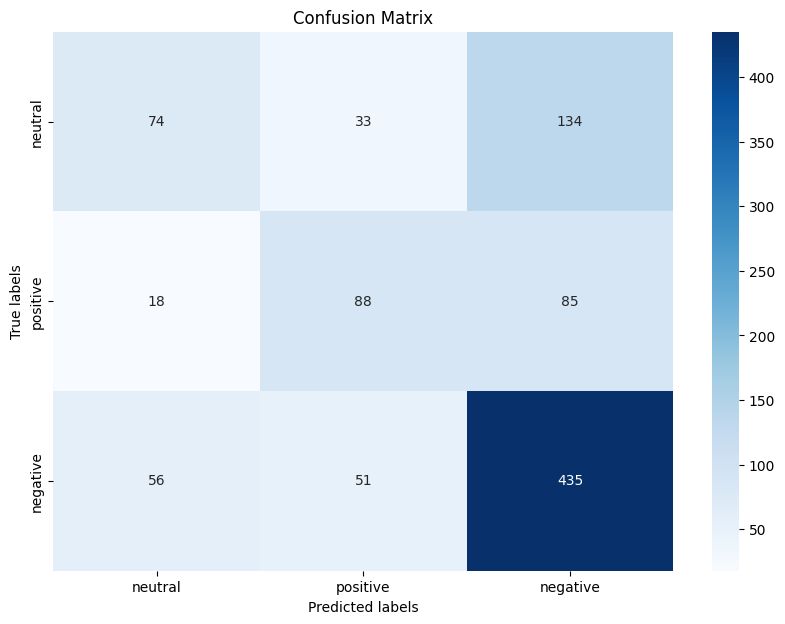

In [25]:
# Generate confusion matrix

cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Remove stuff from gpu and manually garbage collect to free resources
"""
import torch
import gc


# Clear the GPU memory cache
torch.cuda.empty_cache()

# Optionally delete your model and run garbage collection
del model
gc.collect()
"""

'\nimport torch\nimport gc\n\n\n# Clear the GPU memory cache\ntorch.cuda.empty_cache()\n\n# Optionally delete your model and run garbage collection\ndel model\ngc.collect()\n'